In [1]:
import pandas as pd
import tensorflow as tf
from transformers import AutoTokenizer
import re
from transformers import AdamWeightDecay
from datasets import Dataset
import math
import numpy as np
from transformers import DataCollatorForSeq2Seq
from transformers import TFAutoModelForSeq2SeqLM
import torch
import matplotlib.pyplot as plt
import evaluate
from transformers import T5Tokenizer, T5Config, T5ForConditionalGeneration
import torch

2023-11-20 11:34:27.441107: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 11:34:32.737572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.config.experimental.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
def json_to_dataframe(filename):
    f = open(filename)
    df = pd.read_json(f)
    print(df.iloc[0])
    f.close()
    df["headline"]= df.apply(lambda x: x['masked headline'].replace('____', str(x['ans'])), axis=1)
    print(df.iloc[0])
    df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
    df['masked headline'] = df['masked headline'].str.replace('____', '<extra_id_0> ') + ' </s>'
    df['text'] = df[['news', 'masked headline']].apply(" ".join, axis=1)
    df = df.astype(str)
    return df

In [4]:
train_data = json_to_dataframe('Train_Numerical_Reasoning.json')

news               (Oct 7, 2014  12:40 PM CDT) As of Jan. 1, Walm...
masked headline    ____K Walmart Part-Timers to Lose Health Insur...
calculation                                     Paraphrase(30,000,K)
ans                                                               30
Name: 0, dtype: object
news               (Oct 7, 2014  12:40 PM CDT) As of Jan. 1, Walm...
masked headline    ____K Walmart Part-Timers to Lose Health Insur...
calculation                                     Paraphrase(30,000,K)
ans                                                               30
headline            30K Walmart Part-Timers to Lose Health Insurance
Name: 0, dtype: object


In [5]:
train_data.head()

,news,masked headline,calculation,ans,headline,text
0,"As of Jan. 1, Walmart will no longer offer 30...",<extra_id_0> K Walmart Part-Timers to Lose Hea...,"Paraphrase(30,000,K)",30,30K Walmart Part-Timers to Lose Health Insurance,"As of Jan. 1, Walmart will no longer offer 30..."
1,Dax Shepard and Kristen Bell got married at t...,Dax Shepard: Wedding to Kristen Bell Cost $<ex...,Copy(142),142,Dax Shepard: Wedding to Kristen Bell Cost $142,Dax Shepard and Kristen Bell got married at t...
2,"Nancy Reagan, the helpmate, backstage adviser...",Nancy Reagan Dead at <extra_id_0> </s>,Copy(94),94,Nancy Reagan Dead at 94,"Nancy Reagan, the helpmate, backstage adviser..."
3,American Airlines faces FAA fines of more tha...,American Airlines Faces $<extra_id_0> M Fine f...,Copy(7),7,American Airlines Faces $7M Fine for Safety Vi...,American Airlines faces FAA fines of more tha...
4,"Ingrid Lyne, the Seattle mom allegedly murder...",$<extra_id_0> K Raised for Kids of Mom Dismemb...,"Paraphrase(222,000,K)",222,$222K Raised for Kids of Mom Dismembered on Date,"Ingrid Lyne, the Seattle mom allegedly murder..."


In [6]:
dataset = Dataset.from_pandas(train_data)
dataset = dataset.train_test_split(test_size=0.2)

In [2]:
model_name = "MBZUAI/LaMini-Flan-T5-783M"

In [8]:
def preprocess_function(examples):   
    inputs = tokenizer(examples['text'],max_length=3024,  truncation=True)
    labels = tokenizer(text_target=examples["headline"], max_length=128, truncation=True)
    inputs["labels"] = labels["input_ids"]
    return inputs

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [10]:
tokenized = dataset.map(preprocess_function, batched=True, #num_proc=4,
                        remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/16925 [00:00<?, ? examples/s]

Map:   0%|          | 0/4232 [00:00<?, ? examples/s]

In [4]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer,
                                           model=model_name,
                                           return_tensors="tf")
#optimizer = AdamWeightDecay(learning_rate=1e-4, weight_decay_rate=0.01)
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)


In [12]:
model = TFAutoModelForSeq2SeqLM.from_pretrained(model_name, from_pt=True)

2023-11-20 07:49:03.589846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:81:00.0, compute capability: 7.0
2023-11-20 07:49:03.590774: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31141 MB memory:  -> device: 1, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:c1:00.0, compute capability: 7.0
/home/u3/hinokicrum/.local/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing th

To convert datasets to the tf.data.Dataset format 

In [13]:
tf_train_set = model.prepare_tf_dataset(
    tokenized["train"],
    shuffle=True,
    batch_size=3,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized["test"],
    shuffle=False,
    batch_size=3,
    collate_fn=data_collator,
)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [14]:
model.compile(optimizer=optimizer)

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

history = model.fit(x=tf_train_set, validation_data=tf_test_set,  epochs=10, callbacks=[callback])
#model.fit(x=tf_train_set, validation_data=tf_test_set, batch_size=6, epochs=1)
#eval_loss = model.evaluate(tf_test_set)
#print(f"Finetuned Perplexity: {math.exp(eval_loss):.2f}")

Epoch 1/10
5641/5641 [==============================] - 2668s 463ms/step - loss: 0.0693 - val_loss: 0.0371
Epoch 2/10
5641/5641 [==============================] - 2612s 463ms/step - loss: 0.0318 - val_loss: 0.0377


In [16]:
model.save('OneStep.keras')


/home/u3/hinokicrum/.local/lib/python3.9/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


In [4]:
model = tf.keras.models.load_model('OneStep.keras')


2023-11-20 11:34:55.009052: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:81:00.0, compute capability: 7.0
2023-11-20 11:34:55.009762: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31141 MB memory:  -> device: 1, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:c1:00.0, compute capability: 7.0
/home/u3/hinokicrum/.local/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


/home/u3/hinokicrum/.local/lib/python3.9/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


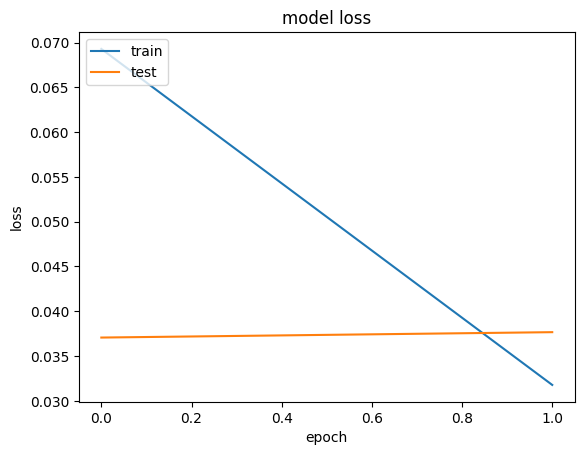

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [5]:
f = open('Dev_Numerical_Reasoning.json')
df = pd.read_json(f)
df['news'] = df['news'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
df['masked headline'] = df['masked headline'].str.replace('____', '<extra_id_0> ') + ' </s>'
df['text'] = df[['news', 'masked headline']].apply(" ".join, axis=1)
df = df.astype(str)
f.close()
test_data = Dataset.from_pandas(df)

In [6]:
def t5_predictions(data, tokenizer, model):
    text = data['text']
    headline = data['masked headline']
    print(headline)
    inputs = tokenizer.encode_plus(text, add_special_tokens=True,
                                   return_tensors="pt").input_ids

    outputs = model.generate(inputs,
                             max_length=128, num_beams=5, early_stopping=True)

    _0_index = headline.index('<extra_id_0> ')
    print(_0_index)

    res = ''
    results = tokenizer.decode(outputs[0][1:], skip_special_tokens=False,
                               clean_up_tokenization_spaces=False)
    print("Pred: ", results)

    res = re.findall(r"(\d+[./]?\d*)", results[_0_index:_0_index+50])
    if len(res) < 1:
        res = re.findall(r"(\d+[./]?\d*)", results)
    try:
        return res[0]
    except:
        return None

To load the ROUGE metric which stands for Recall-Oriented Understudy for Gisting Evaluation to calculates the similarity between the predicted headlines and actual headlines. ROUGE-N measures the number of matching n-grams between the model-generated text and an actual headline.



In [7]:
tru = 0
predictions = []
for i in test_data:
    prediction1 = t5_predictions(i, tokenizer, model)
    predictions.append(prediction1)
    answer = i['ans']
    print("Answer: ", answer)
    print("Prediction1: ", prediction1)
    print("Calc: ", i['calculation'])
    if answer == prediction1:
        tru += 1
    print("")

<extra_id_0> rd Victim Dead in Quarry Shooting; Manhunt Still On </s>


2023-11-20 11:53:00.637957: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1b7c004790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-20 11:53:00.638018: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2023-11-20 11:53:00.638026: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100S-PCIE-32GB, Compute Capability 7.0
2023-11-20 11:53:00.643637: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-20 11:53:00.678625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2023-11-20 11:53:00.688941: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:543] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation o

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2023-11-20 11:53:00.934678: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

25
Pred:  USS Pueblo Crew Awarded $65M</s>
Answer:  65
Prediction1:  65
Calc:  Copy(65)

Seattle Slaps <extra_id_0> ¢ Fee on All Grocery Bags </s>
14
Pred:  Seattle Slaps 20<unk> Fee on All Grocery Bags</s><pad>
Answer:  20
Prediction1:  20
Calc:  Copy(20)

Dow Edges Up <extra_id_0>  Points </s>
13
Pred:  Dow Edges Up 3 Points</s><pad>
Answer:  2
Prediction1:  3
Calc:  Copy(2)

Secession Gets Green Light in <extra_id_0>  Colorado Counties </s>
30
Pred:  Secession Gets Green Light in 6 Colorado Counties</s>
Answer:  6
Prediction1:  6
Calc:  Copy(6)

Bankrupt <extra_id_0>  Cent Now Suing His Ex-Lawyers </s>
9
Pred:  Bankrupt 50 Cent Now Suing His Ex-Lawyers</s>
Answer:  50
Prediction1:  50
Calc:  Copy(50)

When It Comes to Tech Bubbles, 2011 Is Not <extra_id_0>  </s>
43
Pred:  When It Comes to Tech Bubbles, 2011 Is Not 2010</s>
Answer:  2000
Prediction1:  2010
Calc:  Subtract(2011,11)

Slim Gain Is Dow's <extra_id_0> rd in Row </s>
19
Pred:  Slim Gain Is Dow's 3rd in Row</s>
Answer:  3
P

107
Pred:  House Speaker John Boehner Rejects President Obama's Request to Address Joint Session of Congress on Sept. 7</s>
Answer:  7
Prediction1:  7
Calc:  Copy(7)

Ford Surprises With $<extra_id_0> M Q1 Profit </s>
21
Pred:  Ford Surprises With $100M Q1 Profit</s><pad>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

<extra_id_0>  Students Arrested After Chemical 'Device' Goes Off </s>
0
Pred:  2 Students Arrested After Chemical 'Device' Goes Off</s>
Answer:  2
Prediction1:  2
Calc:  Trans(Two)

<extra_id_0>  Winning Powerball Tickets Sold </s>
0
Pred:  2 Winning Powerball Tickets Sold</s>
Answer:  2
Prediction1:  2
Calc:  Add(Span(Arizona),Span(Missouri))

Humans Push Earth Past <extra_id_0>  of 9 Danger Zones </s>
23
Pred:  Humans Push Earth Past 4 of 9 Danger Zones</s>
Answer:  4
Prediction1:  4
Calc:  Trans(four)

Floridian Is Now <extra_id_0> rd to Die of Seawater Bacteria </s>
17
Pred:  Floridian Is Now 3rd to Die of Seawater Bacteria</s>
Answer:  3
Prediction1:  3
Calc:  Tran

0
Pred:  30 Years Later, Wyoming Fugitive Caught in Alaska</s>
Answer:  31
Prediction1:  30
Calc:  Subtract(2012-1981)

Bruni to G<extra_id_0> : Don't Let Recession Kill AIDS Funding </s>
10
Pred:  Bruni to G8: Don't Let Recession Kill AIDS Funding</s><pad>
Answer:  8
Prediction1:  8
Calc:  Copy(8)

Shakespeare Gets a <extra_id_0> -Year-Old Drug Test </s>
19
Pred:  Shakespeare Gets a 400-Year-Old Drug Test</s><pad>
Answer:  400
Prediction1:  400
Calc:  Copy(400)

Elizabeth Edwards Dead at <extra_id_0>  </s>
26
Pred:  Elizabeth Edwards Dead at 60</s>
Answer:  61
Prediction1:  60
Calc:  Copy(61)

New EU Sanctions Hit Maker of AK-<extra_id_0>  </s>
33
Pred:  New EU Sanctions Hit Maker of AK-47</s>
Answer:  47
Prediction1:  47
Calc:  Copy(47)

Zimmerman Sues NBC Over <extra_id_0>  Tape Edits </s>
24
Pred:  Zimmerman Sues NBC Over 911 Tape Edits</s><pad>
Answer:  911
Prediction1:  911
Calc:  Copy(911)

Big <extra_id_0>  Execs Finish With Senate </s>
4
Pred:  Big 3 Execs Finish With Senate</

10
Pred:  Who isn't at risk in Rio de Janeiro? More Than 30 Men Sought in Gang Rape of Teen Girl</s><pad>
Answer:  30
Prediction1:  30
Calc:  Copy(30)

'<extra_id_0>  Days of Christmas' Gifts Will Cost You $97K </s>
1
Pred:  '364 Days of Christmas' Gifts Will Cost You $97K</s>
Answer:  12
Prediction1:  364
Calc:  Copy(12)

<extra_id_0>  Injured by Turbulence on Flight From Rio </s>
0
Pred:  4 Injured by Turbulence on Flight From Rio</s><pad>
Answer:  26
Prediction1:  4
Calc:  Add(22,Trans(four))

Aussie Aerial Shoot Could Cull <extra_id_0> M Camels </s>
31
Pred:  Aussie Aerial Shoot Could Cull 1M Camels</s><pad>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

Romney's Cash Edge: $<extra_id_0> M </s>
21
Pred:  Romney's Cash Edge: $91M</s>
Answer:  62
Prediction1:  91
Calc:  Subtract(186,124)

Coke Bids $<extra_id_0> B for Chinese Juice Company </s>
11
Pred:  Coke Bids $2.4B for Chinese Juice Company</s>
Answer:  2.4
Prediction1:  2.4
Calc:  Copy(2.4)

Stimulus Gave $<extra_id_0> M to Faith-B

0
Pred:  200 Farmworkers Beheaded in Guatemala</s>
Answer:  27
Prediction1:  200
Calc:  Add(25,Trans(two))

Jon Stewart Adopts Pony Hit With <extra_id_0>  Paintballs </s>
33
Pred:  Jon Stewart Adopts Pony Hit With 125 Paintballs</s>
Answer:  125
Prediction1:  125
Calc:  Copy(125)

Missing: <extra_id_0> -Year-Old; 20 Inches Long, Big Nose </s>
9
Pred:  Missing: 5-Year-Old; 20 Inches Long, Big Nose</s><pad>
Answer:  5
Prediction1:  5
Calc:  Copy(5)

Facebook: Defining Religion in <extra_id_0>  Characters </s>
31
Pred:  Facebook: Defining Religion in 100 Characters</s><pad>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

China Quarantines <extra_id_0>  Yanks </s>
18
Pred:  China Quarantines 2 Yanks</s>
Answer:  2
Prediction1:  2
Calc:  Trans(Two)

Dow Ends Day Up <extra_id_0>  </s>
16
Pred:  Dow Ends Day Up 22</s>
Answer:  22
Prediction1:  22
Calc:  Copy(22)

Court: Man in Solitary Since <extra_id_0>  Can Be Tried 3rd Time </s>
29
Pred:  Court: Man in Solitary Since 1972 Can Be Tried 3rd

29
Pred:  Bush Unveils Record-Busting $3.1T Budget</s>
Answer:  3
Prediction1:  3.1
Calc:  Copy(3)

Woman Gets $<extra_id_0> K Over Endless Cable Robocalls </s>
12
Pred:  Woman Gets $229K Over Endless Cable Robocalls</s>
Answer:  230
Prediction1:  229
Calc:  Round(Paraphrase(229,500,k),0)

Ford: We'll Add 12K Jobs Over <extra_id_0>  Years </s>
30
Pred:  Ford: We'll Add 12K Jobs Over 3 Years</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

Man May Have Paid $<extra_id_0> K to Kill Africa's Most Famous Lion </s>
19
Pred:  Man May Have Paid $55K to Kill Africa's Most Famous Lion</s>
Answer:  55
Prediction1:  55
Calc:  Paraphrase(55,000,K)

Vet Stands on Bridge <extra_id_0>  Hours to Honor Victims in Tennessee </s>
21
Pred:  Vet Stands on Bridge 4 Hours to Honor Victims in Tennessee</s><pad>
Answer:  4
Prediction1:  4
Calc:  Trans(four)

Man Willing to Lose Job Over <extra_id_0> -Minute Diversity Video </s>
29
Pred:  Man Willing to Lose Job Over 17-Minute Diversity Video</s>
Answer:  17

0
Pred:  12% of Your Spices May Be Contaminated With 'Filth'</s>
Answer:  12
Prediction1:  12
Calc:  Copy(12)

North Korea Claims 'Worst Drought in <extra_id_0>  Years' </s>
37
Pred:  North Korea Claims 'Worst Drought in 100 Years'</s>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

G-<extra_id_0>  Pledges to Keep Stimulus Flowing </s>
2
Pred:  G-20 Pledges to Keep Stimulus Flowing</s><pad>
Answer:  20
Prediction1:  20
Calc:  Copy(20)

Obama Might 'Refine' <extra_id_0> -Month Iraq Timeline </s>
21
Pred:  Obama Might 'Refine' 16-Month Iraq Timeline</s>
Answer:  16
Prediction1:  16
Calc:  Copy(16)

Americans Elect on Ballot in <extra_id_0>  States and Counting </s>
29
Pred:  Americans Elect on Ballot in 17 States and Counting</s>
Answer:  17
Prediction1:  17
Calc:  Copy(17)

Here's Who's Getting What From Bowie's $<extra_id_0> M Estate </s>
40
Pred:  Here's Who's Getting What From Bowie's $100M Estate</s><pad>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

IPO Talks Peg Value of Group

23
Pred:  Judge Releases Frantic 911 Call in Hudson Murder Trial</s><pad>
Answer:  911
Prediction1:  911
Calc:  Copy(911)

Dow Falls <extra_id_0>  on Jobs Data </s>
10
Pred:  Dow Falls 169 on Jobs Data</s>
Answer:  19
Prediction1:  169
Calc:  Round(223.32,0)

Boy Who Fought 'Aging Disease' Dead at <extra_id_0>  </s>
39
Pred:  Boy Who Fought 'Aging Disease' Dead at 17</s>
Answer:  17
Prediction1:  17
Calc:  Copy(17)

Beyonce Shoutout Spikes Red Lobster Sales by <extra_id_0> % </s>
45
Pred:  Beyonce Shoutout Spikes Red Lobster Sales by 33%</s>
Answer:  33
Prediction1:  33
Calc:  Copy(33)

US Malaria Experiments in <extra_id_0> s Left Troops 'Ruined' </s>
26
Pred:  US Malaria Experiments in 1940s Left Troops 'Ruined'</s><pad>
Answer:  1940
Prediction1:  1940
Calc:  Copy(1940)

Teen: Berlusconi Gave Me $<extra_id_0> K </s>
26
Pred:  Teen: Berlusconi Gave Me $9.5K</s>
Answer:  9
Prediction1:  9.5
Calc:  Round(Paraphrase(9,350,K),0)

Burger King Brings Back Yumbo—After <extra_id_0>  Years </

23
Pred:  Wildfire Now Arizona's 2nd-Biggest Ever</s><pad>
Answer:  2
Prediction1:  2
Calc:  Trans(second)

Economists See High Unemployment Through <extra_id_0>  </s>
41
Pred:  Economists See High Unemployment Through 2010</s>
Answer:  2010
Prediction1:  2010
Calc:  Copy(2010)

Nun, <extra_id_0> , Guilty of Breaking Into Nuclear Plant </s>
5
Pred:  Nun, 83, Guilty of Breaking Into Nuclear Plant</s>
Answer:  83
Prediction1:  83
Calc:  Copy(83)

Steven Tyler Snags $<extra_id_0> M for Memoir </s>
20
Pred:  Steven Tyler Snags $2M for Memoir</s><pad>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

Carnival Samba Queen, <extra_id_0> , Breaks Down </s>
22
Pred:  Carnival Samba Queen, 7, Breaks Down</s><pad>
Answer:  7
Prediction1:  7
Calc:  Copy(7)

South African Named Miss World <extra_id_0>  </s>
31
Pred:  South African Named Miss World 2014</s>
Answer:  2014
Prediction1:  2014
Calc:  Copy(2014)

4 Shot, <extra_id_0>  Killed at NYC Rap Concert </s>
8
Pred:  4 Shot, 1 Killed at NYC Rap Concert</

0
Pred:  31 Dead in 3 Blasts Near Baghdad Hotels</s>
Answer:  31
Prediction1:  31
Calc:  Copy(31)

Man Who Made Gummi Bears Famous Dead at <extra_id_0>  </s>
40
Pred:  Man Who Made Gummi Bears Famous Dead at 90</s><pad>
Answer:  90
Prediction1:  90
Calc:  Copy(90)

<extra_id_0> -Year-Old Woman Sues to Keep From Being Evicted </s>
0
Pred:  97-Year-Old Woman Sues to Keep From Being Evicted</s>
Answer:  97
Prediction1:  97
Calc:  Copy(97)

Colossal Chinese Dustball Circles Earth in <extra_id_0>  Days </s>
43
Pred:  Colossal Chinese Dustball Circles Earth in 13 Days</s>
Answer:  13
Prediction1:  13
Calc:  Copy(13)

<extra_id_0>  US Troops Killed in Attack on Afghan Base </s>
0
Pred:  2 US Troops Killed in Attack on Afghan Base</s>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

Voice of Judy Jetson Dies at Age <extra_id_0>  </s>
33
Pred:  Voice of Judy Jetson Dies at Age 96</s>
Answer:  96
Prediction1:  96
Calc:  Copy(96)

Saudis Bumping Oil Flow <extra_id_0> % to Slow Soaring Prices </s>
24
Pr

0
Pred:  3 Dead in Massive Kansas Explosion</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

<extra_id_0>  Music Legends Who Never Cracked the Top 40 </s>
0
Pred:  11 Music Legends Who Never Cracked the Top 40</s>
Answer:  11
Prediction1:  11
Calc:  Copy(11)

July Home Sales Plummet <extra_id_0> % </s>
24
Pred:  July Home Sales Plummet 27%</s>
Answer:  27.2
Prediction1:  27
Calc:  Round(Multiply(Divide(Subtract(5.26,3.83),5.26),100),1)

Oil Dips Below $<extra_id_0>  for First Time in 5 Months </s>
16
Pred:  Oil Dips Below $100 for First Time in 5 Months</s><pad>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

Fracking Quakes Could Be Avoided ... for $<extra_id_0> M Per Well </s>
42
Pred:  Fracking Quakes Could Be Avoided ... for $10M Per Well</s>
Answer:  10
Prediction1:  10
Calc:  Copy(10)

<extra_id_0>  Cops Fired After Pulling Students From Car Amid Protest </s>
0
Pred:  2 Cops Fired After Pulling Students From Car Amid Protest</s>
Answer:  2
Prediction1:  2
Calc:  Trans(two)

W

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

0
Pred:  22-Year-Old Vies to Be First Woman to Scale 'Murder Wall'</s>
Answer:  22
Prediction1:  22
Calc:  Copy(22)

<extra_id_0>  Charged in Sick Ice-Bucket Prank on Autistic Boy </s>
0
Pred:  5 Charged in Sick Ice-Bucket Prank on Autistic Boy</s>
Answer:  5
Prediction1:  5
Calc:  Trans(five)

Family of <extra_id_0>  Dead in Phoenix Shooting, Fire </s>
10
Pred:  Family of 5 Dead in Phoenix Shooting, Fire</s>
Answer:  5
Prediction1:  5
Calc:  Trans(five)

Russian Theory Blames Ukraine for MH<extra_id_0>  </s>
36
Pred:  Russian Theory Blames Ukraine for MH17</s><pad>
Answer:  17
Prediction1:  17
Calc:  Copy(17)

<extra_id_0> % Remain Facebook Friends With Exes </s>
0
Pred:  60% Remain Facebook Friends With Exes</s><pad>
Answer:  60
Prediction1:  60
Calc:  Copy(60)

Driver Delivers $6 Pizza, Is Tipped $<extra_id_0> K </s>
37
Pred:  Driver Delivers $6 Pizza, Is Tipped $1K</s><pad>
Answer:  1
Prediction1:  1
Calc:  Paraphrase(1,000,K)

Family Thinks Parents Killed <extra_id_0>  Kids, Selve

20
Pred:  EPA Official Stole $900K by Not Showing Up for Work</s>
Answer:  900
Prediction1:  900
Calc:  Paraphrase(900,000,K)

Drew Peterson Guilty in <extra_id_0> rd Wife's Murder </s>
24
Pred:  Drew Peterson Guilty in 3rd Wife's Murder</s>
Answer:  3
Prediction1:  3
Calc:  Copy(3)

After <extra_id_0>  Years, Most-Wanted Fugitive Caught in Cancun </s>
6
Pred:  After 24 Years, Most-Wanted Fugitive Caught in Cancun</s><pad>
Answer:  24
Prediction1:  24
Calc:  Copy(24)

Allegiant Air Had More Than 100 Big Problems in <extra_id_0>  Years </s>
48
Pred:  Allegiant Air Had More Than 100 Big Problems in 2 Years</s>
Answer:  2
Prediction1:  2
Calc:  Trans(two)

Dudes Devour <extra_id_0> -Pound Goat to Break Cubs' Curse </s>
13
Pred:  Dudes Devour 40-Pound Goat to Break Cubs' Curse</s>
Answer:  40
Prediction1:  40
Calc:  Copy(40)

Cops Rescue Family From Irate <extra_id_0> -lb. Cat </s>
30
Pred:  Cops Rescue Family From Irate 22-lb. Cat</s>
Answer:  22
Prediction1:  22
Calc:  Copy(22)

<extra_i

5
Pred:  Even 3-Year-Olds Want to Be Thin</s>
Answer:  3
Prediction1:  3
Calc:  Copy(3)

Freddie Has 4th-Straight Loss as <extra_id_0> nd Quarter Charges Rise </s>
33
Pred:  Freddie Has 4th-Straight Loss as 2nd Quarter Charges Rise</s><pad>
Answer:  2
Prediction1:  2
Calc:  Trans(second)

iPad 3 to Be Unveiled March <extra_id_0>  </s>
28
Pred:  iPad 3 to Be Unveiled March 7</s>
Answer:  7
Prediction1:  7
Calc:  Copy(7)

3 Dead, Over <extra_id_0>  Injured in Harlem Blast </s>
13
Pred:  3 Dead, Over 50 Injured in Harlem Blast</s>
Answer:  50
Prediction1:  50
Calc:  Copy(50)

New York Times Endorses <extra_id_0>  Democrats for President </s>
24
Pred:  New York Times Endorses 2 Democrats for President</s>
Answer:  2
Prediction1:  2
Calc:  Trans(two)

Car Sharing Rides $<extra_id_0>  Gas to Increased Popularity </s>
19
Pred:  Car Sharing Rides $4 Gas to Increased Popularity</s>
Answer:  4
Prediction1:  4
Calc:  Copy(4)

New York City Record: No Murders in <extra_id_0>  Days </s>
36
Pred:  N

34
Pred:  Kidnapped Girl Had First Child at 14; Kept in Backyard Shed</s>
Answer:  14
Prediction1:  14
Calc:  Copy(14)

She Was Stalked by a Wolf for <extra_id_0>  Hours. Then the Bear Came </s>
30
Pred:  She Was Stalked by a Wolf for 12 Hours. Then the Bear Came</s>
Answer:  12
Prediction1:  12
Calc:  Copy(12)

<extra_id_0>  out of 10 Young Adults Moving Home </s>
0
Pred:  3 out of 10 Young Adults Moving Home</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

He Arrested <extra_id_0>  6-Year-Olds. Now, the Police Chief's Decision </s>
12
Pred:  He Arrested 2 6-Year-Olds. Now, the Police Chief's Decision</s>
Answer:  2
Prediction1:  2
Calc:  Trans(two)

YouTube to Go <extra_id_0> D </s>
14
Pred:  YouTube to Go 3D</s>
Answer:  3
Prediction1:  3
Calc:  Copy(3)

<extra_id_0>  Citadel Cadets Disciplined in 'KKK' Flap </s>
0
Pred:  14 Citadel Cadets Disciplined in 'KKK' Flap</s>
Answer:  14
Prediction1:  14
Calc:  Trans(Fourteen)

By Next Year, Richest 1% to Own More Than Other <extra_id_0

28
Pred:  How One New Yorker Lives in 90 Square Feet</s>
Answer:  90
Prediction1:  90
Calc:  Copy(90)

Ancient Crystals Rewrite <extra_id_0> M Years of History </s>
25
Pred:  Ancient Crystals Rewrite 300M Years of History</s><pad>
Answer:  300
Prediction1:  300
Calc:  Copy(300)

Photogs Mistake 'Blondie,' <extra_id_0> , for Lindsay Lohan </s>
27
Pred:  Photogs Mistake 'Blondie,' for Lindsay Lohan</s><pad>
Answer:  66
Prediction1:  None
Calc:  Copy(66)

The Edge Rejects Greenie Criticism of U<extra_id_0>  Tour </s>
39
Pred:  The Edge Rejects Greenie Criticism of U2 Tour</s>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

<extra_id_0>  Injured in Clash Outside Beijing Apple Store </s>
0
Pred:  4 Injured in Clash Outside Beijing Apple Store</s>
Answer:  4
Prediction1:  4
Calc:  Copy(4)

Nigeria Sentences <extra_id_0>  'Cowardly' Soldiers to Death </s>
18
Pred:  Nigeria Sentences 54 'Cowardly' Soldiers to Death</s><pad>
Answer:  54
Prediction1:  54
Calc:  Copy(54)

<extra_id_0>  Dead, 20 Hurt i

21
Pred:  India's Tata Debuts $2,500 Car</s>
Answer:  2,500
Prediction1:  2
Calc:  Copy(2,500)

Deep-Sea Sub Vanishes <extra_id_0>  Miles Down </s>
22
Pred:  Deep-Sea Sub Vanishes 6.2 Miles Down</s>
Answer:  6
Prediction1:  6.2
Calc:  Round(6.2,0)

Drug Gunmen Attack <extra_id_0>  Mexican Army Bases </s>
19
Pred:  Drug Gunmen Attack 2 Mexican Army Bases</s>
Answer:  2
Prediction1:  2
Calc:  Trans(two)

<extra_id_0> th-Ranked Aussie Stuns Rafael Nadal </s>
0
Pred:  144th-Ranked Aussie Stuns Rafael Nadal</s>
Answer:  144
Prediction1:  144
Calc:  Copy(144)

<extra_id_0>  Killed in Baghdad Mosque Bombings </s>
0
Pred:  29 Killed in Baghdad Mosque Bombings</s><pad>
Answer:  29
Prediction1:  29
Calc:  Copy(29)

Avatar Success Sparks <extra_id_0> D Rush in Tinseltown </s>
22
Pred:  Avatar Success Sparks 3D Rush in Tinseltown</s>
Answer:  3
Prediction1:  3
Calc:  Copy(3)

Madoff Got $<extra_id_0> M Investment Days Before Arrest: Suit </s>
12
Pred:  Madoff Got $10M Investment Days Before Arrest

19
Pred:  Time Warner Posts $16B Loss on Declining Media Value</s>
Answer:  16
Prediction1:  16
Calc:  Copy(16)

Scholar Finds <extra_id_0>  More Dead Sea Scrolls </s>
14
Pred:  Scholar Finds 9 More Dead Sea Scrolls</s>
Answer:  9
Prediction1:  9
Calc:  Trans(nine)

By Next Year, Richest <extra_id_0> % to Own More Than Other 99% </s>
22
Pred:  By Next Year, Richest 1% to Own More Than Other 99%</s>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

Mexican Novelist Carlos Fuentes Dead at <extra_id_0>  </s>
40
Pred:  Mexican Novelist Carlos Fuentes Dead at 83</s>
Answer:  83
Prediction1:  83
Calc:  Copy(83)

At <extra_id_0>  Inches, Insect Is World's Longest </s>
3
Pred:  At 23 Inches, Insect Is World's Longest</s><pad>
Answer:  22.3
Prediction1:  23
Calc:  Copy(22.3)

Life for Syrian Refugees, at $<extra_id_0> K a Day </s>
30
Pred:  Life for Syrian Refugees, at $500K a Day</s><pad>
Answer:  500
Prediction1:  500
Calc:  Paraphrase(500,000,K)

Dow Falls <extra_id_0>  in Mixed Day </s>
10
Pred:  

26
Pred:  Dress Like a Mad Man for $998</s><pad>
Answer:  998
Prediction1:  998
Calc:  Copy(998)

Japan Will Sell More Adult Diapers Than Baby Diapers by <extra_id_0>  </s>
56
Pred:  Japan Will Sell More Adult Diapers Than Baby Diapers by 2020</s><pad>
Answer:  2020
Prediction1:  2020
Calc:  Copy(2020)

Shanghai High-Rise Inferno Kills <extra_id_0>  </s>
33
Pred:  Shanghai High-Rise Inferno Kills 42</s>
Answer:  42
Prediction1:  42
Calc:  Copy(42)

<extra_id_0>  in Kamala Harris' Camp Test Positive </s>
0
Pred:  2 in Kamala Harris' Camp Test Positive</s>
Answer:  2
Prediction1:  2
Calc:  Trans(Two)

Spain's $1.2B 'Ghost Airport' Could Sell—for $<extra_id_0> K </s>
46
Pred:  Spain's $1.2B 'Ghost Airport' Could Sell—for $10K</s><pad>
Answer:  11
Prediction1:  10
Calc:  Round(Paraphrase(10,800,K),0)

<extra_id_0> -Year-Old Finishes Half-Marathon —by Mistake </s>
0
Pred:  12-Year-Old Finishes Half-Marathon —by Mistake</s>
Answer:  12
Prediction1:  12
Calc:  Copy(12)

Obama Hiking Minimum W

0
Pred:  40 Radio Stations to Drop Limbaugh, Hannity: Source</s>
Answer:  40
Prediction1:  40
Calc:  Copy(40)

Police Identify Virginia Tech Gunman as Ross Truett Ashley, <extra_id_0>  </s>
60
Pred:  Police Identify Virginia Tech Gunman as Ross Truett Ashley, 22</s>
Answer:  22
Prediction1:  22
Calc:  Copy(22)

Airlines Pledge to Halve Emissions by <extra_id_0>  </s>
38
Pred:  Airlines Pledge to Halve Emissions by 50%</s><pad>
Answer:  2050
Prediction1:  50
Calc:  Copy(2050)

Transgender Girl Scout, <extra_id_0> , Triggers Cookie Boycott Call </s>
24
Pred:  Transgender Girl Scout, 7, Triggers Cookie Boycott Call</s><pad>
Answer:  7
Prediction1:  7
Calc:  Copy(7)

Dessert Contest Prize: $<extra_id_0> K Home </s>
24
Pred:  Dessert Contest Prize: $390K Home</s>
Answer:  390
Prediction1:  390
Calc:  Paraphrase(390,000,K)

TWA Flight <extra_id_0>  Crash Not as Reported: Documentary </s>
11
Pred:  TWA Flight 800 Crash Not as Reported: Documentary</s><pad>
Answer:  800
Prediction1:  800
Calc:

24
Pred:  Fannie Mae's Task: Sell 65K Homes in Buyer's Market</s><pad>
Answer:  65
Prediction1:  65
Calc:  Paraphrase(65,000,K)

Chick-fil-A Owner Pays Staff During <extra_id_0> -Month Remodel </s>
36
Pred:  Chick-fil-A Owner Pays Staff During 5-Month Remodel</s><pad>
Answer:  5
Prediction1:  5
Calc:  Trans(five)

Blasts Again Sweep Iraq; <extra_id_0>  Killed </s>
25
Pred:  Blasts Again Sweep Iraq; 26 Killed</s>
Answer:  26
Prediction1:  26
Calc:  Copy(26)

Marathon Runner Raises $<extra_id_0> K After Death </s>
24
Pred:  Marathon Runner Raises $400K After Death</s>
Answer:  400
Prediction1:  400
Calc:  Paraphrase(400,000,k)

<extra_id_0>  Men Arrested in Jussie Smollett Case Released </s>
0
Pred:  2 Men Arrested in Jussie Smollett Case Released</s>
Answer:  2
Prediction1:  2
Calc:  Trans(two)

Noda Gain: Japan Gets <extra_id_0> th Leader in 5 Years </s>
22
Pred:  Noda Gain: Japan Gets 6th Leader in 5 Years</s>
Answer:  6
Prediction1:  6
Calc:  Trans(sixth)

$<extra_id_0> K Awarded to 

29
Pred:  Whistleblower: VA Covered Up 7 Deaths</s>
Answer:  7
Prediction1:  7
Calc:  Copy(7)

Pair Finds Dog Lost <extra_id_0>  Days in Yellowstone </s>
20
Pred:  Pair Finds Dog Lost 42 Days in Yellowstone</s><pad>
Answer:  42
Prediction1:  42
Calc:  Copy(42)

EPA to Seek <extra_id_0> % Drop in Carbon Emissions </s>
12
Pred:  EPA to Seek 30% Drop in Carbon Emissions</s><pad>
Answer:  30
Prediction1:  30
Calc:  Copy(30)

<extra_id_0> M Android Forum Users' Data Hacked </s>
0
Pred:  1M Android Forum Users' Data Hacked</s><pad>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

SpaceX Just Got 'Leaner' Ahead of <extra_id_0>  Costly Projects </s>
34
Pred:  SpaceX Just Got 'Leaner' Ahead of 2 Costly Projects</s>
Answer:  2
Prediction1:  2
Calc:  Trans(two)

Wal-Mart Gives Workers $<extra_id_0> B in Bonuses, Rewards </s>
24
Pred:  Wal-Mart Gives Workers $2B in Bonuses, Rewards</s><pad>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

<extra_id_0>  Charged in Biggest Financial Hacking Case </s>
0
Pred:  4

47
Pred:  Prediction: We'll Discover 1st 'Earth Twin' in 2013</s>
Answer:  2013
Prediction1:  2013
Calc:  Copy(2013)

Great-Grandpa Mick Jagger to Be a Dad for <extra_id_0> th Time </s>
42
Pred:  Great-Grandpa Mick Jagger to Be a Dad for 8th Time</s>
Answer:  8
Prediction1:  8
Calc:  Trans(eighth)

<extra_id_0>  Dead, Over 50 Injured in Harlem Blast </s>
0
Pred:  3 Dead, Over 50 Injured in Harlem Blast</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

How a Stolen Stradivarius Surfaced After <extra_id_0>  Years </s>
41
Pred:  How a Stolen Stradivarius Surfaced After 35 Years</s>
Answer:  35
Prediction1:  35
Calc:  Copy(35)

<extra_id_0>  Homes Collapse in New China Aftershock </s>
0
Pred:  70,000 Homes Collapse in New China Aftershock</s>
Answer:  70,000
Prediction1:  70
Calc:  Copy(70,000)

Why the USPS Has Lost $<extra_id_0> B in Alaska </s>
23
Pred:  Why the USPS Has Lost $2.5B in Alaska</s><pad>
Answer:  2.5
Prediction1:  2.5
Calc:  Copy(2.5)

New GOP Budget Would Cut $<extra_id_

13
Pred:  Obama Blows $8.3B on Reelection Trick</s>
Answer:  8
Prediction1:  8.3
Calc:  Round(8.3,0)

Boy, <extra_id_0> , Charged in Fatal Shooting of Brother, 3 </s>
5
Pred:  Boy, 11, Charged in Fatal Shooting of Brother, 3</s>
Answer:  11
Prediction1:  11
Calc:  Copy(11)

Petraeus <extra_id_0> ? GOP Mulls New Candidates </s>
9
Pred:  Petraeus 2012? GOP Mulls New Candidates</s>
Answer:  2012
Prediction1:  2012
Calc:  Copy(2012)

Jamaica Toll Hits <extra_id_0>  as Manhunt Goes On </s>
18
Pred:  Jamaica Toll Hits 73 as Manhunt Goes On</s>
Answer:  73
Prediction1:  73
Calc:  Copy(73)

Suicide Bomber Kills <extra_id_0>  at Pakistan Mosque </s>
21
Pred:  Suicide Bomber Kills 21 at Pakistan Mosque</s>
Answer:  21
Prediction1:  21
Calc:  Copy(21)

5 Climbers Feared Dead on World's <extra_id_0> rd-Highest Peak </s>
34
Pred:  5 Climbers Feared Dead on World's 3rd-Highest Peak</s>
Answer:  3
Prediction1:  3
Calc:  Trans(third)

<extra_id_0>  Officers Killed, 1 Wounded in Calif. Domestic Dispute

31
Pred:  Museum Tells Brazil's Story in 10,000 Voices</s><pad>
Answer:  10,000
Prediction1:  10
Calc:  Copy(10,000)

The Scream Expected to Fetch $<extra_id_0> M at Auction </s>
30
Pred:  The Scream Expected to Fetch $80M at Auction</s>
Answer:  80
Prediction1:  80
Calc:  Copy(80)

Unemployment Rate Falls to <extra_id_0> % </s>
27
Pred:  Unemployment Rate Falls to 9.4%</s>
Answer:  9.4
Prediction1:  9.4
Calc:  Copy(9.4)

Swedish Town Testing Full Pay for <extra_id_0> -Hour Week </s>
34
Pred:  Swedish Town Testing Full Pay for 30-Hour Week</s><pad>
Answer:  30
Prediction1:  30
Calc:  Copy(30)

Williams-Sonoma Founder Dies at <extra_id_0>  </s>
32
Pred:  Williams-Sonoma Founder Dies at 100</s>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

Spend Night in  Jersey Shore Pad —for $<extra_id_0> K </s>
39
Pred:  Spend Night in Jersey Shore Pad —for $2.5K</s>
Answer:  2.5
Prediction1:  5
Calc:  Paraphrase(2,500,K)

Lindsay Lohan Released on $<extra_id_0> K Bail </s>
27
Pred:  Lindsay Lohan 

35
Pred:  'Surreal': Mob Victim's Body Found—23 Years Later</s>
Answer:  23
Prediction1:  23
Calc:  Copy(23)

Swift Wins <extra_id_0> , Kanye Booed at Billboard Awards </s>
11
Pred:  Swift Wins 8, Kanye Booed at Billboard Awards</s><pad>
Answer:  8
Prediction1:  8
Calc:  Trans(eight)

Woman Plagued With Stuffy Nose—for <extra_id_0>  Years </s>
35
Pred:  Woman Plagued With Stuffy Nose—for 18 Years</s>
Answer:  18
Prediction1:  18
Calc:  Copy(18)

Fireworks Explode Into Crowd, Injuring <extra_id_0>  </s>
39
Pred:  Fireworks Explode Into Crowd, Injuring 28</s>
Answer:  28
Prediction1:  28
Calc:  Copy(28)

<extra_id_0> -Year Terms Sought for Pussy Riot Members </s>
0
Pred:  3-Year Terms Sought for Pussy Riot Members</s><pad>
Answer:  3
Prediction1:  3
Calc:  Copy(3)

Bachmann Will Form <extra_id_0>  Committee </s>
19
Pred:  Bachmann Will Form 2012 Committee</s>
Answer:  2012
Prediction1:  2012
Calc:  Copy(2012)

Canada OKs World's <extra_id_0> st Stem Cell Therapy </s>
19
Pred:  Canada OKs

8
Pred:  3 Dead, 3 Hurt in Vegas Strip Shooting</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

Doctors Find <extra_id_0> -Inch Worm Living in Man's Eye </s>
13
Pred:  Doctors Find 5-Inch Worm Living in Man's Eye</s><pad>
Answer:  5
Prediction1:  5
Calc:  Copy(5)

Burned Baby, Nurse Reunite After <extra_id_0>  Years </s>
33
Pred:  Burned Baby, Nurse Reunite After 38 Years</s>
Answer:  38
Prediction1:  38
Calc:  Copy(38)

No. <extra_id_0> : Illinois Legalizes Medical Marijuana </s>
4
Pred:  No. 20: Illinois Legalizes Medical Marijuana</s>
Answer:  20
Prediction1:  20
Calc:  Copy(20)

<extra_id_0>  Dead in Colo. Shooting at Dark Knight  Movie </s>
0
Pred:  12 Dead in Colo. Shooting at Dark Knight Movie</s><pad>
Answer:  12
Prediction1:  12
Calc:  Copy(12)

Insects Caught in the Act —in <extra_id_0> M-Year-Old Fossil </s>
30
Pred:  Insects Caught in the Act —in 165M-Year-Old Fossil</s><pad>
Answer:  165
Prediction1:  165
Calc:  Copy(165)

Dr Peppers All Around If GNR Finishes <extra_i

0
Pred:  1 Shot as Ferguson Protesters Defy Curfew</s>
Answer:  1
Prediction1:  1
Calc:  Trans(one)

Meet Jesse James' Mistresses No. 2 and No. <extra_id_0>  </s>
43
Pred:  Meet Jesse James' Mistresses No. 2 and No. 3</s>
Answer:  3
Prediction1:  3
Calc:  Copy(3)

Grandmother Thumbs Nose at Heirs, Shreds $<extra_id_0> M </s>
42
Pred:  Grandmother Thumbs Nose at Heirs, Shreds $1M</s><pad>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

Cops: Grocery Worker Stuffed $<extra_id_0> K Worth of Meat in Pants </s>
30
Pred:  Cops: Grocery Worker Stuffed $1.2K Worth of Meat in Pants</s>
Answer:  1.2
Prediction1:  1.2
Calc:  Paraphrase(1,200,K)

2010 to Bring <extra_id_0>  GOP Promises </s>
14
Pred:  2010 to Bring 10 GOP Promises</s><pad>
Answer:  10
Prediction1:  10
Calc:  Copy(10)

To Eat This <extra_id_0> K-Calorie Breakfast, Sign a Waiver </s>
12
Pred:  To Eat This 8K-Calorie Breakfast, Sign a Waiver</s><pad>
Answer:  8
Prediction1:  8
Calc:  Paraphrase(8,000,K)

$<extra_id_0>  Bill Goes 3D </s>
1

1
Pred:  $500K in Legal Bills May Have Motivated Blago</s><pad>
Answer:  500
Prediction1:  500
Calc:  Paraphrase(500,000,k)

Investor Group Gets Its Claws on PetSmart for $<extra_id_0> B </s>
47
Pred:  Investor Group Gets Its Claws on PetSmart for $8.7B</s>
Answer:  8.7
Prediction1:  8.7
Calc:  Copy(8.7)

<extra_id_0>  Oakland Cops Killed; Another on Life Support </s>
0
Pred:  3 Oakland Cops Killed; Another on Life Support</s>
Answer:  3
Prediction1:  3
Calc:  Trans(Three)

Dow Ends Day Up <extra_id_0>  </s>
16
Pred:  Dow Ends Day Up 284</s>
Answer:  284
Prediction1:  284
Calc:  Copy(284)

Missing $<extra_id_0> M Lottery Winner Likely Murdered </s>
9
Pred:  Missing $30M Lottery Winner Likely Murdered</s><pad>
Answer:  30
Prediction1:  30
Calc:  Copy(30)

Iran Gives Hikers <extra_id_0>  Years </s>
18
Pred:  Iran Gives Hikers 8 Years</s><pad>
Answer:  8
Prediction1:  8
Calc:  Copy(8)

Shoe Hurler Gets <extra_id_0>  Years in Prison </s>
17
Pred:  Shoe Hurler Gets 3 Years in Prison</s><pad

26
Pred:  Shooter's Neighbor Called 911, Was Told Open Carry Is Legal</s><pad>
Answer:  911
Prediction1:  911
Calc:  Copy(911)

San Francisco's Median Home Price: $<extra_id_0> M </s>
36
Pred:  San Francisco's Median Home Price: $1M</s><pad>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

'<extra_id_0> s Boy-Band Singer Suing Kanye West </s>
1
Pred:  '70s Boy-Band Singer Suing Kanye West</s>
Answer:  70
Prediction1:  70
Calc:  Subtract(1970,1900)

'Colombia Fritzl' Fathered <extra_id_0>  Kids With Daughter </s>
27
Pred:  'Colombia Fritzl' Fathered 11 Kids With Daughter</s>
Answer:  11
Prediction1:  11
Calc:  Copy(11)

GM: We're Giving $<extra_id_0> M to Ignition-Switch Victims </s>
18
Pred:  GM: We're Giving $400M to Ignition-Switch Victims</s>
Answer:  400
Prediction1:  400
Calc:  Copy(400)

Postmaster Wants to Drop Delivery <extra_id_0>  Day a Week </s>
34
Pred:  Postmaster Wants to Drop Delivery 1 Day a Week</s>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

John's Drunk Tape Fetches $<extra

10
Pred:  EPA Shuts 17 Fracking Wells After Okla.'s Strongest Quake</s>
Answer:  17
Prediction1:  17
Calc:  Copy(17)

Rahm's Approval Rating: <extra_id_0> % </s>
24
Pred:  Rahm's Approval Rating: 20%</s><pad>
Answer:  19
Prediction1:  20
Calc:  Copy(19)

Barclays Seeks Liquidity With $<extra_id_0> B Offering </s>
31
Pred:  Barclays Seeks Liquidity With $8.85B Offering</s>
Answer:  8.85
Prediction1:  8.85
Calc:  Copy(8.85)

<extra_id_0>  Killed in Polish Homeless Shelter Fire </s>
0
Pred:  21 Killed in Polish Homeless Shelter Fire</s>
Answer:  21
Prediction1:  21
Calc:  Copy(21)

How Jessica Simpson Built a $<extra_id_0> B Brand </s>
29
Pred:  How Jessica Simpson Built a $1B Brand</s><pad>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

<extra_id_0>  Twister Deaths Highest in a Decade </s>
0
Pred:  98 Twister Deaths Highest in a Decade</s>
Answer:  2008
Prediction1:  98
Calc:  Copy(2008)

How PayPal's Founder Plans to Live to <extra_id_0>  </s>
38
Pred:  How PayPal's Founder Plans to Live to

0
Pred:  54% Against Calif. Gay-Marriage Ban</s>
Answer:  54
Prediction1:  54
Calc:  Copy(54)

Mine That Bird Pulls Off <extra_id_0> -1 Derby Shocker </s>
25
Pred:  Mine That Bird Pulls Off 50-1 Derby Shocker</s>
Answer:  50
Prediction1:  50
Calc:  Copy(50)

<extra_id_0>  Pounds of Cocaine Seized on Cruise Ship in SF </s>
0
Pred:  28 Pounds of Cocaine Seized on Cruise Ship in SF</s>
Answer:  28
Prediction1:  28
Calc:  Copy(28)

Family Guilty of 'Honor Killing' of <extra_id_0>  Daughters, First Wife </s>
36
Pred:  Family Guilty of 'Honor Killing' of 3 Daughters, First Wife</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

Grenade Blows in Inventory Check, Kills <extra_id_0>  Turkish Soldiers </s>
40
Pred:  Grenade Blows in Inventory Check, Kills 25 Turkish Soldiers</s>
Answer:  25
Prediction1:  25
Calc:  Copy(25)

Now <extra_id_0> K Dead Fish Wash Up in Arkansas </s>
4
Pred:  Now 100K Dead Fish Wash Up in Arkansas</s><pad>
Answer:  100
Prediction1:  100
Calc:  Paraphrase(100,000,K)

C

25
Pred:  Driver Flicks Cigarette, 6 Horses Burn to Death</s>
Answer:  6
Prediction1:  6
Calc:  Trans(Six)

First Wild Bison in <extra_id_0>  Years Born East of Mississippi </s>
20
Pred:  First Wild Bison in 200 Years Born East of Mississippi</s><pad>
Answer:  200
Prediction1:  200
Calc:  Copy(200)

A Challenge From a Planet About to House <extra_id_0> B People </s>
41
Pred:  A Challenge From a Planet About to House 7B People</s>
Answer:  7
Prediction1:  7
Calc:  Copy(7)

TSA Paid $<extra_id_0> K for App That Just Showed an Arrow </s>
10
Pred:  TSA Paid $47K for App That Just Showed an Arrow</s>
Answer:  47
Prediction1:  47
Calc:  Round(Paraphrase(47,400 ,K),0)

<extra_id_0> rd-Grader Gives Classmates 60 Bags of Heroin </s>
0
Pred:  3rd-Grader Gives Classmates 60 Bags of Heroin</s>
Answer:  3
Prediction1:  3
Calc:  Trans(third)

Atop Deadly K<extra_id_0> , Climbers Hit Perfect Storm of Tragedy </s>
13
Pred:  Atop Deadly K2, Climbers Hit Perfect Storm of Tragedy</s><pad>
Answer:  2
Pred

32
Pred:  FEMA Wants Homeowners to Repay $5M in Sandy Aid</s><pad>
Answer:  5.8
Prediction1:  5
Calc:  Copy(5.8)

'Stand by Me' Singer Dead at <extra_id_0>  </s>
29
Pred:  'Stand by Me' Singer Dead at 76</s>
Answer:  76
Prediction1:  76
Calc:  Copy(76)

The <extra_id_0>  Best Super Bowl Ads </s>
4
Pred:  The 10 Best Super Bowl Ads</s>
Answer:  10
Prediction1:  10
Calc:  Copy(10)

US Spent $<extra_id_0> B Spinning Wheels on High-Speed Rail </s>
10
Pred:  US Spent $11B Spinning Wheels on High-Speed Rail</s>
Answer:  11
Prediction1:  11
Calc:  Copy(11)

Scientists Find Clues to Sailors' Legendary <extra_id_0>  Survival </s>
44
Pred:  Scientists Find Clues to Sailors' Legendary 1813 Survival</s>
Answer:  1813
Prediction1:  1813
Calc:  Copy(1813)

Stocks Gyrate; Dow Down <extra_id_0>  </s>
24
Pred:  Stocks Gyrate; Dow Down 37</s>
Answer:  37
Prediction1:  37
Calc:  Round(37.27,0)

Giuliani: If I Were Trump, I'd Blow Off Last <extra_id_0>  Debates </s>
45
Pred:  Giuliani: If I Were Trump, I'

49
Pred:  Company Promises 'Mess-Free Period Sex,' Raises $1M</s><pad>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

Samsung: Stop Using 'Improved' Galaxy Note <extra_id_0>  </s>
43
Pred:  Samsung: Stop Using 'Improved' Galaxy Note 7</s>
Answer:  7
Prediction1:  7
Calc:  Copy(7)

Bono's Surgery Delays U2 Tour Until <extra_id_0>  </s>
36
Pred:  Bono's Surgery Delays U2 Tour Until next year</s>
Answer:  2011
Prediction1:  2
Calc:  Add(2010,Span(next year))

Casino to Gamblers: You Owe Us $<extra_id_0> M </s>
32
Pred:  Casino to Gamblers: You Owe Us $1.5M</s>
Answer:  1.5
Prediction1:  1.5
Calc:  Copy(1.5)

Man Scored $<extra_id_0> K in Retirement Checks ... for His Dead Father </s>
12
Pred:  Man Scored $500K in Retirement Checks ... for His Dead Father</s><pad>
Answer:  500
Prediction1:  500
Calc:  Paraphrase(500,000,K)

Cops: <extra_id_0>  Dead, 2 Hurt in Coast Guardsman's Rampage </s>
6
Pred:  Cops: 1 Dead, 2 Hurt in Coast Guardsman's Rampage</s>
Answer:  1
Prediction1:  1
Calc:  Trans(on

16
Pred:  Dow Ends Day Up 222</s>
Answer:  222
Prediction1:  222
Calc:  Copy(222)

Ex-Wife Loses Appeal in $<extra_id_0> B Divorce </s>
25
Pred:  Ex-Wife Loses Appeal in $18B Divorce</s>
Answer:  1
Prediction1:  18
Calc:  Round(Paraphrase(Multiply(974,1000),M),0)

<extra_id_0>  Hurt in Amusement Park Log Ride Crash </s>
0
Pred:  3 Hurt in Amusement Park Log Ride Crash</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

North West Wears $<extra_id_0> K Earrings, and Other Lavish Details </s>
18
Pred:  North West Wears $50K Earrings, and Other Lavish Details</s><pad>
Answer:  50
Prediction1:  50
Calc:  Paraphrase(50,000 ,K)

<extra_id_0>  Years Later, Murder Suspect Found—Living as Church Deacon </s>
0
Pred:  33 Years Later, Murder Suspect Found—Living as Church Deacon</s>
Answer:  33
Prediction1:  33
Calc:  Copy(33)

22 Years Later, Waiters Still Work for $<extra_id_0>  a Hour </s>
40
Pred:  22 Years Later, Waiters Still Work for $2.13 a Hour</s>
Answer:  2.13
Prediction1:  2.13
Calc:  

0
Pred:  600-Year-Old Bra Blows Hole in History of Lingerie</s>
Answer:  600
Prediction1:  600
Calc:  Copy(600)

Obama to Send <extra_id_0>  More US Troops to Iraq </s>
14
Pred:  Obama to Send 200 More US Troops to Iraq</s><pad>
Answer:  200
Prediction1:  200
Calc:  Copy(200)

Yahoo, Alibaba End Years of Bickering With $<extra_id_0> B Deal </s>
44
Pred:  Yahoo, Alibaba End Years of Bickering With $7.1B Deal</s>
Answer:  7
Prediction1:  7.1
Calc:  Round(7.1,0)

Slain Newlywed Gave Wrong Address to <extra_id_0>  </s>
37
Pred:  Slain Newlywed Gave Wrong Address to 4025</s>
Answer:  911
Prediction1:  4025
Calc:  Copy(911)

Death Toll in Guatemala Mudslide Reaches <extra_id_0>  </s>
41
Pred:  Death Toll in Guatemala Mudslide Reaches 56</s><pad>
Answer:  56
Prediction1:  56
Calc:  Copy(56)

Sex Slave Raped <extra_id_0>  Times Over Weekend: Report </s>
16
Pred:  Sex Slave Raped 90 Times Over Weekend: Report</s>
Answer:  90
Prediction1:  90
Calc:  Copy(90)

Charles, Camilla Cut Personal Spendi

46
Pred:  Geyser Erupts, Out Pours Trash Dating Back to 1930s</s>
Answer:  1930
Prediction1:  1930
Calc:  Copy(1930)

San Jose Standoff Ends With <extra_id_0>  Dead </s>
28
Pred:  San Jose Standoff Ends With 4 Dead</s>
Answer:  5
Prediction1:  4
Calc:  Add(Trans(four),Span(turned the gun on himself))

Fidel Castro Gives <extra_id_0> -Hour Talk on ... </s>
19
Pred:  Fidel Castro Gives 6-Hour Talk on ...</s>
Answer:  6
Prediction1:  6
Calc:  Trans(six)

Wife of NFL QB Home After <extra_id_0> -Hour Brain Surgery </s>
26
Pred:  Wife of NFL QB Home After 12-Hour Brain Surgery</s><pad>
Answer:  12
Prediction1:  12
Calc:  Copy(12)

US Boots <extra_id_0>  Saudi Cadets After Pensacola Rampage </s>
9
Pred:  US Boots 21 Saudi Cadets After Pensacola Rampage</s><pad>
Answer:  21
Prediction1:  21
Calc:  Copy(21)

Mexican Gunmen Kill Elite Cop, <extra_id_0>  Kids </s>
31
Pred:  Mexican Gunmen Kill Elite Cop, 6 Kids</s>
Answer:  6
Prediction1:  6
Calc:  Trans(six)

A Repeal of <extra_id_0> nd Amendmen

31
Pred:  Ruling May Help Solve Infamous 1946 Lynching</s>
Answer:  1946
Prediction1:  1946
Calc:  Copy(1946)

After <extra_id_0> -Week Quarantine, Americans Fly to Antarctica </s>
6
Pred:  After 6-Week Quarantine, Americans Fly to Antarctica</s><pad>
Answer:  6
Prediction1:  6
Calc:  Trans(six)

Studio Confirms Matrix <extra_id_0>  </s>
23
Pred:  Studio Confirms Matrix 4</s><pad>
Answer:  4
Prediction1:  4
Calc:  Copy(4)

Freak Accident at NC Beach Kills Father of <extra_id_0>  </s>
43
Pred:  Freak Accident at NC Beach Kills Father of 3</s>
Answer:  6
Prediction1:  3
Calc:  Trans(six)

Hurricane Survivor, <extra_id_0> , Was Sent to Migrant Detention Center </s>
20
Pred:  Hurricane Survivor, 12, Was Sent to Migrant Detention Center</s>
Answer:  12
Prediction1:  12
Calc:  Copy(12)

Trump Announces Where $<extra_id_0> K of His Salary Will Go </s>
23
Pred:  Trump Announces Where $100K of His Salary Will Go</s>
Answer:  100
Prediction1:  100
Calc:  Paraphrase(100,000,K)

These Critters Jus

31
Pred:  Rape Kit That Sat Untested for 11 Years Turns Up a Match</s>
Answer:  11
Prediction1:  11
Calc:  Copy(11)

All Eyes on Mississippi and Last Election of <extra_id_0>  </s>
45
Pred:  All Eyes on Mississippi and Last Election of 2018</s>
Answer:  2018
Prediction1:  2018
Calc:  Copy(2018)

<extra_id_0>  Missing After Massive Dock Fire </s>
0
Pred:  7 Missing After Massive Dock Fire</s>
Answer:  7
Prediction1:  7
Calc:  Trans(seven)

Alabama Tornado Killed <extra_id_0>  Members of Same Family </s>
23
Pred:  Alabama Tornado Killed 7 Members of Same Family</s>
Answer:  7
Prediction1:  7
Calc:  Trans(seven)

Framed Picture Falls, Killing Boy, <extra_id_0>  </s>
35
Pred:  Framed Picture Falls, Killing Boy, 4</s>
Answer:  4
Prediction1:  4
Calc:  Copy(4)

Queen Knights a Hero, <extra_id_0>  </s>
22
Pred:  Queen Knights a Hero, 100</s>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

Berlusconi Hospitalized With COVID-<extra_id_0>  </s>
35
Pred:  Berlusconi Hospitalized With COVID-19</s

37
Pred:  Trump Already Knows Who Will Run His 2020 Campaign</s><pad>
Answer:  2020
Prediction1:  2020
Calc:  Copy(2020)

Latest Outbreak of Tainted Alcohol Kills <extra_id_0>  </s>
41
Pred:  Latest Outbreak of Tainted Alcohol Kills 19</s>
Answer:  19
Prediction1:  19
Calc:  Copy(19)

US Hits <extra_id_0> M Cases, Just 15 Days After Last Milestone </s>
8
Pred:  US Hits 4M Cases, Just 15 Days After Last Milestone</s><pad>
Answer:  4
Prediction1:  4
Calc:  Copy(4)

Ban on <extra_id_0> D-Printed Gun Instructions Will Remain </s>
7
Pred:  Ban on 3D-Printed Gun Instructions Will Remain</s><pad>
Answer:  3
Prediction1:  3
Calc:  Copy(3)

What's a Threat to Our Health Worldwide? WHO's Top <extra_id_0>  </s>
51
Pred:  What's a Threat to Our Health Worldwide? WHO's Top 10</s>
Answer:  10
Prediction1:  10
Calc:  Copy(10)

She Went Viral at <extra_id_0> , Published a Book by 4 </s>
18
Pred:  She Went Viral at 2, Published a Book by 4</s>
Answer:  2
Prediction1:  2
Calc:  Copy(2)

On 2nd Day of Ra

13
Pred:  She Offered $25K to Catch a Killer. Now, She's Charged</s><pad>
Answer:  25
Prediction1:  25
Calc:  Paraphrase(25,000,K)

<extra_id_0> K N. Korean Defectors Just Got Hacked </s>
0
Pred:  1K N. Korean Defectors Just Got Hacked</s><pad>
Answer:  1
Prediction1:  1
Calc:  Paraphrase(1,000,K)

Keystone's <extra_id_0> nd Big Spill in 2 Years: 'What's Going On?' </s>
11
Pred:  Keystone's 2nd Big Spill in 2 Years: 'What's Going On?'</s><pad>
Answer:  2
Prediction1:  2
Calc:  Trans(second)

At Least <extra_id_0>  Die After Dam Collapse at Gold Mine </s>
9
Pred:  At Least 15 Die After Dam Collapse at Gold Mine</s>
Answer:  15
Prediction1:  15
Calc:  Copy(15)

<extra_id_0> st Frat Brother Sentenced in Penn State Hazing Death Case </s>
0
Pred:  1st Frat Brother Sentenced in Penn State Hazing Death Case</s><pad>
Answer:  1
Prediction1:  1
Calc:  Trans(first)

<extra_id_0>  Dead in Shooting Outside Kansas Elementary School </s>
0
Pred:  1 Dead in Shooting Outside Kansas Elementary School</

39
Pred:  Cop Finds Driver Playing Pokemon Go on 8 Phones</s>
Answer:  8
Prediction1:  8
Calc:  Copy(8)

<extra_id_0>  Killed, Dozens Hurt in Oregon Tour Bus Crash </s>
0
Pred:  9 Killed, Dozens Hurt in Oregon Tour Bus Crash</s>
Answer:  9
Prediction1:  9
Calc:  Trans(Nine)

Flint's Water Not Tested Even After <extra_id_0>  Deaths From Legionnaires' </s>
36
Pred:  Flint's Water Not Tested Even After 9 Deaths From Legionnaires'</s>
Answer:  9
Prediction1:  9
Calc:  Trans(nine)

Judge Tells Wisconsin to Take <extra_id_0> K Off Voting Rolls </s>
30
Pred:  Judge Tells Wisconsin to Take 243K Off Voting Rolls</s>
Answer:  230
Prediction1:  243
Calc:  Paraphrase(230,000,K)

Guy Who Made $<extra_id_0> K Got Tax Refund of $980K </s>
14
Pred:  Guy Who Made $3.8K Got Tax Refund of $980K</s>
Answer:  3.5
Prediction1:  3.8
Calc:  Round(Paraphrase(3,497,K),1)

Trump Postpones G<extra_id_0>  </s>
17
Pred:  Trump Postpones G7</s><pad>
Answer:  7
Prediction1:  7
Calc:  Copy(7)

Obama Takes <extra_id_0>

36
Pred:  Indie Film Pioneer Dies Suddenly at 54</s>
Answer:  54
Prediction1:  54
Calc:  Copy(54)

Ted Turner Has <extra_id_0>  Lovers— One for Every Week of Month </s>
15
Pred:  Ted Turner Has 4 Lovers— One for Every Week of Month</s>
Answer:  4
Prediction1:  4
Calc:  Trans(four)

Ex-Student Charged <extra_id_0>  Years After School Burned to Ground </s>
19
Pred:  Ex-Student Charged 23 Years After School Burned to Ground</s>
Answer:  23
Prediction1:  23
Calc:  Copy(23)

Don't Lick That Spoon: <extra_id_0> M Boxes of Cake Mix Recalled </s>
23
Pred:  Don't Lick That Spoon: 2M Boxes of Cake Mix Recalled</s>
Answer:  2.4
Prediction1:  2
Calc:  Copy(2.4)

Rare Portrait of Mozart at <extra_id_0>  Could Bring $1M </s>
27
Pred:  Rare Portrait of Mozart at 1770 Could Bring $1M</s><pad>
Answer:  13
Prediction1:  1770
Calc:  Copy(13)

A Student-Loan Debt 'Bomb' Is Going to Go Off in <extra_id_0>  </s>
49
Pred:  A Student-Loan Debt 'Bomb' Is Going to Go Off in 2027</s>
Answer:  2027
Prediction1:  

21
Pred:  Former NFLer Donates 3rd Home: This Is 'Therapy'</s><pad>
Answer:  173
Prediction1:  3
Calc:  Copy(173)

Incredibly Rare Species Seen for First Time in <extra_id_0>  Years </s>
47
Pred:  Incredibly Rare Species Seen for First Time in 30 Years</s>
Answer:  30
Prediction1:  30
Calc:  Copy(30)

How Wall Street Grabbed $<extra_id_0> B&mdash;and Your House </s>
25
Pred:  How Wall Street Grabbed $60B&mdash;and Your House</s><pad>
Answer:  60
Prediction1:  60
Calc:  Copy(60)

China Clears Over <extra_id_0>  Tons of Trash From Mt. Everest </s>
18
Pred:  China Clears Over 9 Tons of Trash From Mt. Everest</s>
Answer:  9
Prediction1:  9
Calc:  Copy(9)

150 Friends on Facebook? You're Close to Only <extra_id_0>  </s>
46
Pred:  150 Friends on Facebook? You're Close to Only 4</s><pad><pad><pad>
Answer:  4
Prediction1:  4
Calc:  Trans(four)

Gaza Exodus in <extra_id_0> th Day as Egypt Fails to Seal Border </s>
15
Pred:  Gaza Exodus in 4th Day as Egypt Fails to Seal Border</s>
Answer:  4
Pre

48
Pred:  First US Baby of 2018 Wasn't Born in Any of the 50 States</s>
Answer:  50
Prediction1:  50
Calc:  Copy(50)

Source: Robert Pattinson Has COVID-<extra_id_0>  </s>
35
Pred:  Source: Robert Pattinson Has COVID-19</s>
Answer:  19
Prediction1:  19
Calc:  Copy(19)

Leon Redbone, Musician of Mystery, Dies at <extra_id_0>  </s>
43
Pred:  Leon Redbone, Musician of Mystery, Dies at 69</s>
Answer:  69
Prediction1:  69
Calc:  Copy(69)

Dow Rises <extra_id_0>  on China Trade Talks </s>
10
Pred:  Dow Rises 400 on China Trade Talks</s><pad>
Answer:  400
Prediction1:  400
Calc:  Copy(400)

Red Sox Win <extra_id_0> th World Series Title in 15 Seasons </s>
12
Pred:  Red Sox Win 4th World Series Title in 15 Seasons</s><pad>
Answer:  4
Prediction1:  4
Calc:  Trans(fourth)

<extra_id_0> -Year-Old Takes Mom's Car, Hits 87mph on Highway </s>
0
Pred:  8-Year-Old Takes Mom's Car, Hits 87mph on Highway</s>
Answer:  8
Prediction1:  8
Calc:  Copy(8)

<extra_id_0> rd NBA Player Tests Positive </s>
0
Pred

0
Pred:  5 Houston Kids Feared Dead in Flood</s><pad>
Answer:  5
Prediction1:  5
Calc:  Trans(five)

<extra_id_0>  Accomplice Released From Prison </s>
0
Pred:  9/11 Accomplice Released From Prison</s>
Answer:  9/11
Prediction1:  9/11
Calc:  Copy(9/11)

SC Company Laying Off All but <extra_id_0>  Workers Over Tariffs </s>
30
Pred:  SC Company Laying Off All but 126 Workers Over Tariffs</s>
Answer:  8
Prediction1:  126
Calc:  Copy(8)

<extra_id_0> K Mice Plagued the Islands. Amazingly, There Are Now None </s>
0
Pred:  200K Mice Plagued the Islands. Amazingly, There Are Now None</s><pad>
Answer:  200
Prediction1:  200
Calc:  Paraphrase(200,000,K)

George HW Bush Dead at <extra_id_0>  </s>
23
Pred:  George HW Bush Dead at 94</s>
Answer:  94
Prediction1:  94
Calc:  Copy(94)

Thai Man Kills <extra_id_0>  in Rampage Sparked by 'Financial Dispute' </s>
15
Pred:  Thai Man Kills 20 in Rampage Sparked by 'Financial Dispute'</s>
Answer:  20
Prediction1:  20
Calc:  Copy(20)

Agency Finds Jump in U

21
Pred:  Man Stole $5M, Blew $4.8M in Head-Scratching Way</s>
Answer:  1
Prediction1:  4.8
Calc:  Copy(1)

<extra_id_0> -Year-Old Girl Falls to Her Death on Carnival Cruise </s>
0
Pred:  8-Year-Old Girl Falls to Her Death on Carnival Cruise</s>
Answer:  8
Prediction1:  8
Calc:  Copy(8)

Per One Poll, Trump's Approval Rating Is Up to <extra_id_0> % </s>
47
Pred:  Per One Poll, Trump's Approval Rating Is Up to 50%</s><pad>
Answer:  50
Prediction1:  50
Calc:  Copy(50)

An Epic Voyage: <extra_id_0>  Years, 40K Miles in Canoe With No GPS </s>
16
Pred:  An Epic Voyage: 3 Years, 40K Miles in Canoe With No GPS</s><pad>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

Woman Born Without Uterus Gives Birth for <extra_id_0> st Time in US </s>
42
Pred:  Woman Born Without Uterus Gives Birth for 1st Time in US</s><pad>
Answer:  1
Prediction1:  1
Calc:  Trans(first)

Recovered Video Shows Pledge Given 18 Drinks in <extra_id_0>  Minutes </s>
48
Pred:  Recovered Video Shows Pledge Given 18 Drinks in 8

15
Pred:  As Recently as 1977, the Sports Bra Didn't Exist</s>
Answer:  1976
Prediction1:  1977
Calc:  Subtract(1977,1)

$<extra_id_0> B Suit on Secret STD Experiment Gets the Go-Ahead </s>
1
Pred:  $1B Suit on Secret STD Experiment Gets the Go-Ahead</s><pad>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

Last Person Born in <extra_id_0> th Century Dies </s>
20
Pred:  Last Person Born in 19th Century Dies</s><pad>
Answer:  19
Prediction1:  19
Calc:  Copy(19)

Neverland Ranch Back on Market, for $<extra_id_0> M Less </s>
37
Pred:  Neverland Ranch Back on Market, for $67M Less</s>
Answer:  33
Prediction1:  67
Calc:  Subtract(100,67)

Arkansas Carries Out 1st US Double Execution Since <extra_id_0>  </s>
51
Pred:  Arkansas Carries Out 1st US Double Execution Since 2000</s>
Answer:  2000
Prediction1:  2000
Calc:  Copy(2000)

Alec Baldwin Collects $<extra_id_0> K Every Time He Plays Trump </s>
23
Pred:  Alec Baldwin Collects $1.4K Every Time He Plays Trump</s>
Answer:  1.4
Prediction1:  1.4
Calc

19
Pred:  Arnold Commissions 8-Foot Bronze Statues of Himself</s>
Answer:  8
Prediction1:  8
Calc:  Trans(eight)

Brad, Angelina Forced to Pay $<extra_id_0> K to Designer </s>
30
Pred:  Brad, Angelina Forced to Pay $730K to Designer</s>
Answer:  730
Prediction1:  730
Calc:  Paraphrase(730,000,K)

More Than <extra_id_0>  Killed, Injured as Taliban Storms Army Base </s>
10
Pred:  More Than 100 Killed, Injured as Taliban Storms Army Base</s>
Answer:  100
Prediction1:  100
Calc:  Copy(100)

Teen's Sock Business Does $<extra_id_0> M in Sales Per Year </s>
27
Pred:  Teen's Sock Business Does $1M in Sales Per Year</s><pad>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

<extra_id_0>  Years After They Went Missing, Sisters Found—and Mom Arrested </s>
0
Pred:  32 Years After They Went Missing, Sisters Found—and Mom Arrested</s>
Answer:  32
Prediction1:  32
Calc:  Copy(32)

5 Dead, <extra_id_0>  Injured as London Tram Derails </s>
8
Pred:  5 Dead, 50 Injured as London Tram Derails</s>
Answer:  50
Pre

18
Pred:  FDA Investigating 5 Deaths Following Obesity Procedure</s>
Answer:  5
Prediction1:  5
Calc:  Trans(five)

California Extends Climate Policy to <extra_id_0>  </s>
37
Pred:  California Extends Climate Policy to 2030</s><pad>
Answer:  2030
Prediction1:  2030
Calc:  Copy(2030)

<extra_id_0>  Klansmen Rally in Va.; 1K Counterprotesters Show Up </s>
0
Pred:  30 Klansmen Rally in Va.; 1K Counterprotesters Show Up</s><pad>
Answer:  50
Prediction1:  30
Calc:  Copy(50)

Fixer Upper Star Sued for More Than $<extra_id_0> M </s>
37
Pred:  Fixer Upper Star Sued for More Than $1M</s><pad>
Answer:  1
Prediction1:  1
Calc:  Copy(1)

Fewer Than <extra_id_0>  da Vinci Paintings Survive. A New Fate for One </s>
11
Pred:  Fewer Than 20 da Vinci Paintings Survive. A New Fate for One</s>
Answer:  20
Prediction1:  20
Calc:  Copy(20)

14 Photos From the Moment Trump Became No. <extra_id_0>  </s>
43
Pred:  14 Photos From the Moment Trump Became No. 45</s>
Answer:  45
Prediction1:  45
Calc:  Copy(45)



4
Pred:  S&P 500, Nasdaq Close at Record Highs</s><pad>
Answer:  500
Prediction1:  500
Calc:  Copy(500)

<extra_id_0>  Dead as City Bus, Tour Bus Collide in NYC </s>
0
Pred:  3 Dead as City Bus, Tour Bus Collide in NYC</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

Federal Debt Soars Past $<extra_id_0> T </s>
25
Pred:  Federal Debt Soars Past $20T</s><pad>
Answer:  20
Prediction1:  20
Calc:  Copy(20)

<extra_id_0> -Day March Against White Supremacy to Begin Monday </s>
0
Pred:  10-Day March Against White Supremacy to Begin Monday</s><pad>
Answer:  10
Prediction1:  10
Calc:  Copy(10)

He Spent <extra_id_0>  Years on the Run. Then Police Received a Tip </s>
9
Pred:  He Spent 30 Years on the Run. Then Police Received a Tip</s>
Answer:  32
Prediction1:  30
Calc:  Subtract(2017,1985)

NCIS: Los Angeles Star Miguel Ferrer Dead at <extra_id_0>  </s>
45
Pred:  NCIS: Los Angeles Star Miguel Ferrer Dead at 60</s>
Answer:  61
Prediction1:  60
Calc:  Copy(61)

Cost of This Drug in 2013: $<ext

0
Pred:  3 Months After Baby, Janet Jackson, Hubby Split</s><pad>
Answer:  3
Prediction1:  3
Calc:  Trans(three)

Jihadist Attack Kills <extra_id_0>  UN Peacekeepers </s>
22
Pred:  Jihadist Attack Kills 3 UN Peacekeepers</s>
Answer:  3
Prediction1:  3
Calc:  Trans(three)



In [8]:
tru

2243

In [10]:
print(tru/len(test_data))

0.8720839813374806
